<h> Image augmentation technology expands the scale of training datasets by making a series of random changes to the 
training images to produce similar, but different, training examples. Another way to explain image augmentation is 
that randomly changing training examples can reduce a model’s dependence on certain properties, thereby improving its 
capability for generalization

In [179]:
import torch
import torchvision
from torch import nn as nn
from torch.nn import functional as F
from torch.utils import data
# from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt
from custom import Accumulator as Accumulator

In [180]:
# from res.plot_lib import plot_data, plot_model, set_default

In [181]:
# set_default()

In [182]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

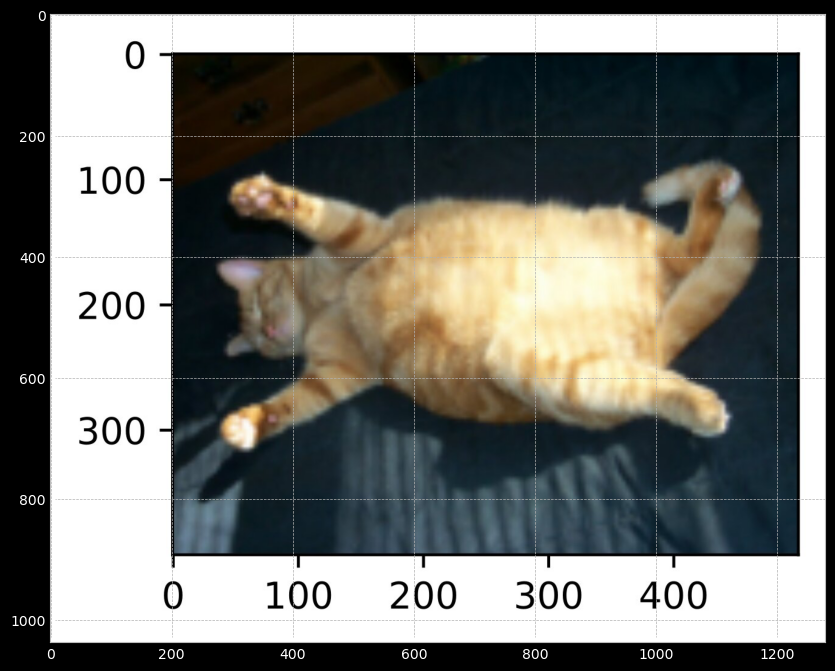

In [183]:
img = Image.open('cat.jpg')
plt.imshow(img)

In [184]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    fig=plt.figure(figsize=(10, 10))
#     Y = [aug(img) for _ in range(num_rows * num_cols)]
    n,m = 0,0
    for i in range(1,num_rows * num_cols):
        Y = aug(img)
        fig.add_subplot(num_rows,num_cols,i)
        plt.imshow(Y)
    plt.show()

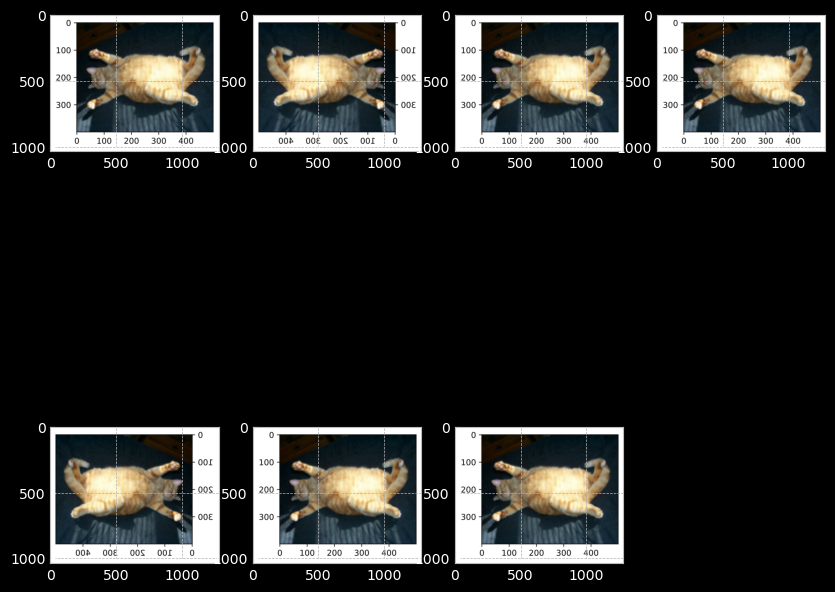

In [185]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

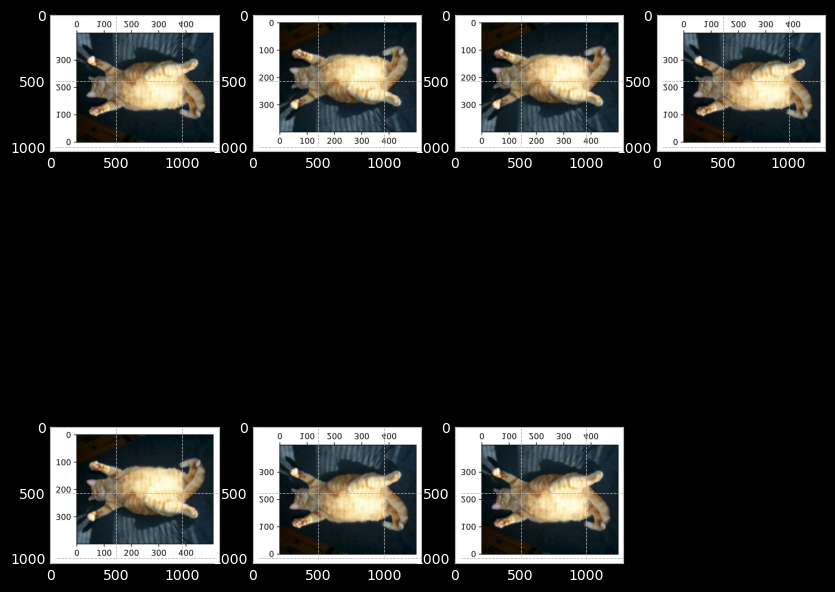

In [186]:
# Flipping up and down is not as commonly used as flipping left and right
apply(img, torchvision.transforms.RandomVerticalFlip())

<h> the cat is in the middle of the image, but this may not be the case for all images
 In addition, we can make objects appear at different positions in the image in different proportions by randomly 
    cropping the image.
 This can also reduce the sensitivity of the model to the target position.

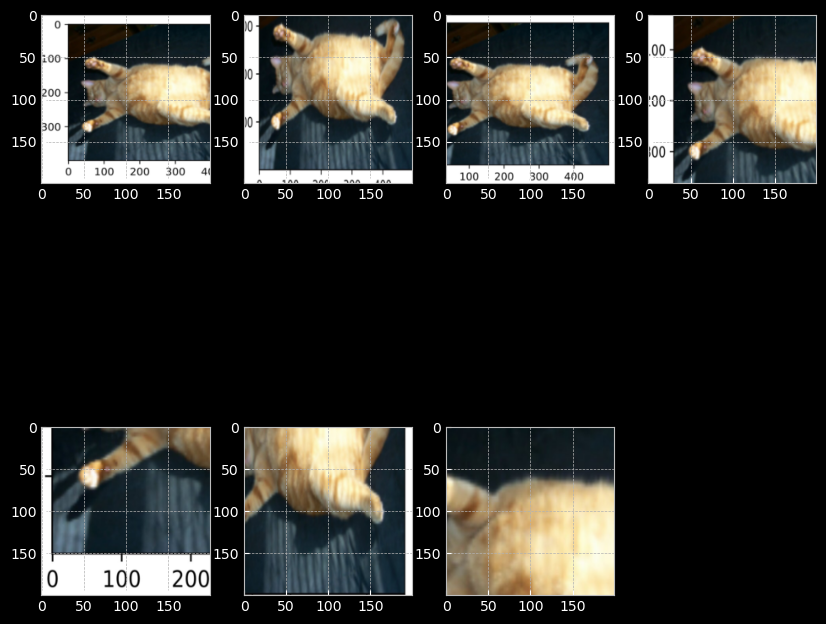

In [187]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

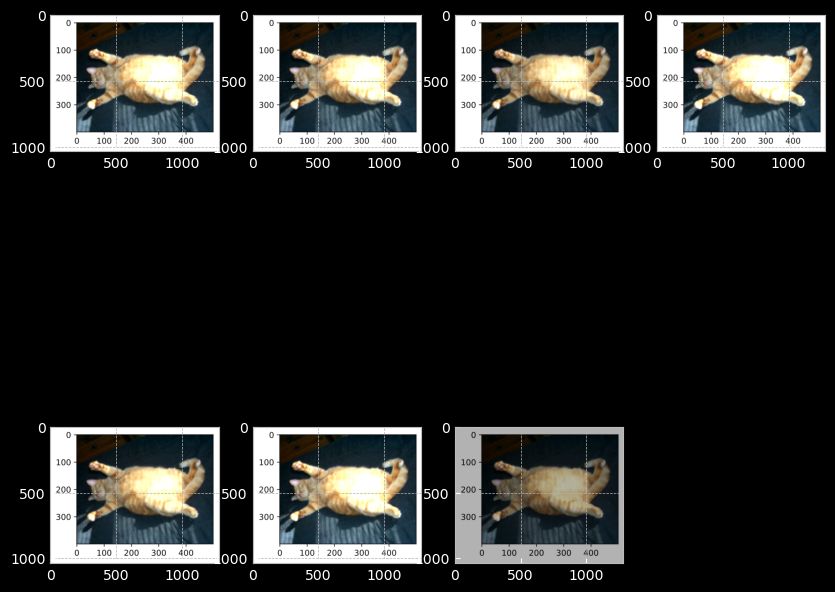

In [188]:
# Changing color
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

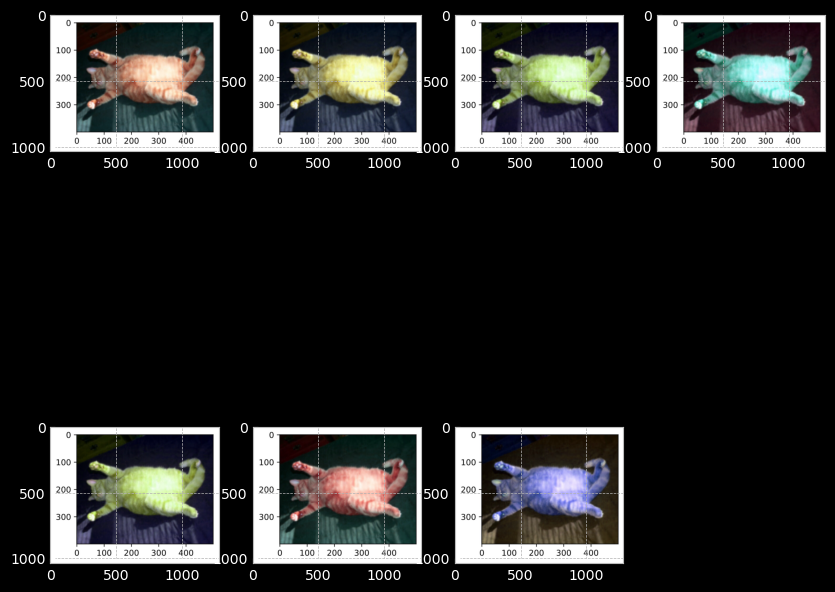

In [189]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

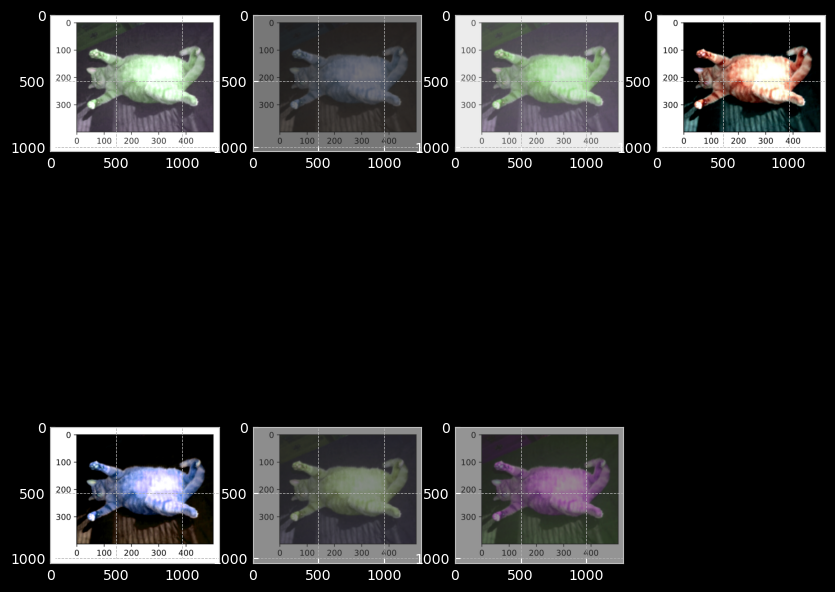

In [190]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

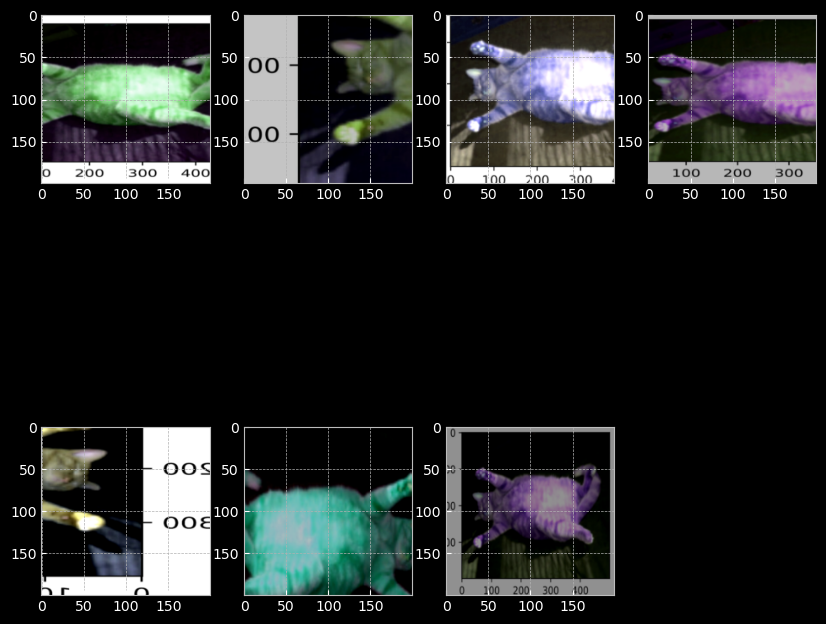

In [191]:
## Multiple Methods Combined
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

In [192]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)

Files already downloaded and verified


In [193]:
# Got data

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])

test_augs =  torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [194]:
def load_Cifar_data(is_train,augs,batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=0)
    return dataloader

In [206]:
## Data Loader Ready

size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
reshape = lambda x, *args, **kwargs: x.reshape(*args, **kwargs)
to = lambda x, *args, **kwargs: x.to(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
transpose = lambda x, *args, **kwargs: x.t(*args, **kwargs)

def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)        
    cmp = astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))


def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required for BERT Fine-tuning (to be covered later)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]

class Residual(nn.Module):
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

def resnet18(num_classes, in_channels=1):
    """A slightly modified ResNet-18 model."""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(in_channels, out_channels,
                                        use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    # This model uses a smaller convolution kernel, stride, and padding and
    # removes the maximum pooling layer
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    return net

In [208]:
def train_batch(net,X,y,loss,trainer,device):
    X = X.to(device)
    y = y.to(device)
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train(net, train_iter, test_iter, loss, trainer, num_epochs):
    num_batches = len(train_iter)
    net = net.to(device)
    for epoch in range(num_epochs):
        print("[EPOCH]", epoch)
        # Store training_loss, training_accuracy, num_examples, num_features
        metric = Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            l, acc = train_batch(
                net, features, labels, loss, trainer, device)
            metric.add(l, acc, labels.shape[0], labels.numel())
        test_acc = evaluate_accuracy_gpu(net, test_iter)
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    

In [210]:
batch_size, net = 256, resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_Cifar_data(True, train_augs, batch_size)
    test_iter = load_Cifar_data(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train(net, train_iter, test_iter, loss, trainer, 5)

In [ ]:
train_with_data_aug(train_augs, test_augs, net)

Files already downloaded and verified
Files already downloaded and verified
[EPOCH] 0
[EPOCH] 1
[EPOCH] 2
[EPOCH] 3
[EPOCH] 4
